In [23]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.utils import np_utils
from tensorflow.keras.optimizers import Adam


In [2]:
#Reading using pandas
train_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-test.csv', header=None)
# Add test dataset into train dataset
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()
# Clear memory
del train_df
del test_df

In [3]:
#Reading the file
label_map = pd.read_csv("./dataset/EMNIST/emnist-balanced-mapping.txt",
                        delimiter = ' ',
                        index_col=0,
                        header=None)
label_map = label_map.iloc[:, 0]

#Initialising an empty dictionary
label_dictionary = {}

#Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [4]:
df.shape


(131600, 785)

In [5]:
df.describe()


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.000000,131600.000000,131600.000000,131600.000000,131600.000000,...,131600.000000,131600.0,131600.0,131600.000000,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.0
mean,23.000000,0.0,0.0,0.0,0.0,0.002036,0.012728,0.019354,0.016284,0.017447,...,0.000266,0.0,0.0,0.001854,0.000243,0.0,0.0,0.0,0.0,0.0
std,13.564712,0.0,0.0,0.0,0.0,0.295477,1.312534,1.586618,1.521459,1.692130,...,0.096481,0.0,0.0,0.672608,0.088211,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


### Preprocessing data


In [6]:
# Is there any missing values
df.dropna(inplace=True)
num_missing_values = df.isnull().sum().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)
num_duplicates = df.duplicated().sum()

# Make sure the grayscale values to be between 0 and 255
df = np.clip(df, 0, 255)
num_values_outside_range = ((df < 0) | (df > 255)).sum().sum()

# Check if we have any null values or duplicated rows or values outside (0, 255) range.
print(f"Any missing value? {num_missing_values}")
print(f"Any duplicates? {num_duplicates}")
print(f"Any values outside the range of 0 and 255? {num_values_outside_range}")

Any missing value? 0
Any duplicates? 0
Any values outside the range of 0 and 255? 0


In [7]:
# We split our dataframe into feature matrix (X) and target vector (y)
X = df.loc[:, 1:]
y = df.loc[:, 0]

X.shape, y.shape

del df

In [8]:
#Data Scaling to bring the input values between 0 to 1
X = X.astype('float32') / 255

# Convert target variable to integer labels
y = y.astype(int)

In [9]:
# Sample entry number 263
sample_image = X.iloc[42]
sample_label = y.iloc[42]
sample_image.shape, sample_label

((784,), 23)

Label entry No. 42: N


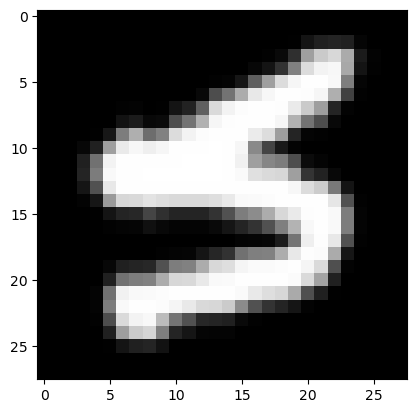

In [10]:
print("Label entry No. 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

In [11]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

Label entry 42: N


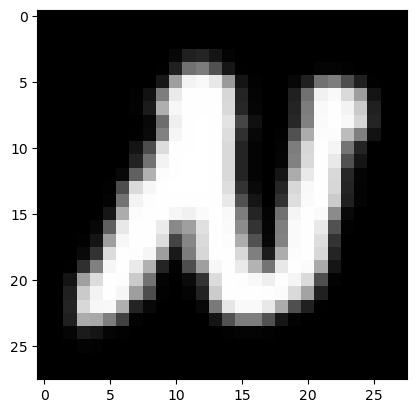

In [12]:
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [13]:
# Next we want to apply reshape_and_rotate to all images in X_train
X = np.asarray(X)
X = np.apply_along_axis(flip_and_rotate, 1, X)
X.shape

(131598, 28, 28)

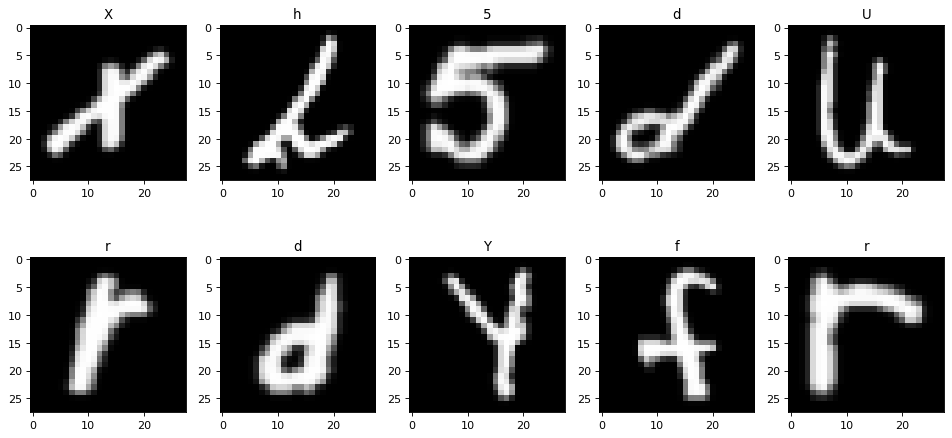

In [14]:
plt.figure(figsize=(12, 6), dpi=80)  # Adjust the figure size to accommodate two rows
for i in range(100, 110):  # Update the range to select 10 samples
    plt.subplot(2, 5, i - 99)  # Use 2 rows and 5 columns for displaying the samples
    plt.imshow(X[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y[i]])
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [15]:
#Finding the number of output columns
number_of_classes = y.nunique()
number_of_classes

47

In [16]:
#One hot encoding of numpy array
y = np_utils.to_categorical(y, number_of_classes)
y.shape

(131598, 47)

In [17]:
# Reshaping the train data
# As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train
X = X.reshape(-1, 28, 28, 1)
X.shape

(131598, 28, 28, 1)

In [18]:
# Split 20% validation 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size= 0.2,
                                                  stratify = y,
                                                  random_state=88)

del X
del y

### Initial Basic Model (Nur)

In [19]:
model = Sequential(
    [              
        tf.keras.Input(shape=(28, 28, 1)),
        Dense(25, activation='relu', name='layer1'),
        Dense(15, activation='relu', name='layer2'),
        Dense(10, activation='linear', name='layer3'),
    ], name = "my_model" 
)
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 28, 28, 25)        50        
                                                                 
 layer2 (Dense)              (None, 28, 28, 15)        390       
                                                                 
 layer3 (Dense)              (None, 28, 28, 10)        160       
                                                                 
Total params: 600 (2.34 KB)
Trainable params: 600 (2.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### CNN Model

In [24]:
# Define the model
model = Sequential()

# Flatten the output of the last convolutional layer
model.add(Flatten(input_shape=(28, 28, 1)))

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.2))

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

# Display the summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 84)                21588     
                                                                 
 dropout (Dropout)           (None, 84)                0         
                                                                 
 dense_4 (Dense)             (None, 47)                3995      
                                                                 
Total params: 226543 (884.93 KB)
Trainable params: 226543 (884.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compile the model with categorical cross-entropy loss, the specified optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Create a ModelCheckpoint callback to save the best model during training based on validation loss
mcp_save = ModelCheckpoint('./saved/nn_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

# Create a ReduceLROnPlateau callback to reduce the learning rate if validation loss plateaus for 3 epochs
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)


In [26]:
# Model Fitting
history = model.fit(X_train,  # Training data features
                    y_train,  # Training data labels
                    epochs=20,  # Number of epochs for training the model
                    batch_size=32,  # Number of samples per gradient update
                    verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
                    validation_data=(X_test, y_test),  # Validation data for evaluating the model
                    callbacks=[mcp_save, early_stopping, RLP])  # Callbacks for additional functionality during training

Epoch 1/20
3282/3290 [============================>.] - ETA: 0s - loss: 1.0848 - accuracy: 0.6749
Epoch 1: val_loss improved from inf to 0.64189, saving model to ./saved\nn_model.h5
3290/3290 [==============================] - 13s 4ms/step - loss: 1.0843 - accuracy: 0.6749 - val_loss: 0.6419 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 2/20
  26/3290 [..............................] - ETA: 13s - loss: 0.7075 - accuracy: 0.7692

D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3282/3290 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.7887
Epoch 2: val_loss improved from 0.64189 to 0.55672, saving model to ./saved\nn_model.h5
3290/3290 [==============================] - 15s 5ms/step - loss: 0.6487 - accuracy: 0.7889 - val_loss: 0.5567 - val_accuracy: 0.8171 - lr: 0.0010
Epoch 3/20
3282/3290 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8133
Epoch 3: val_loss improved from 0.55672 to 0.52960, saving model to ./saved\nn_model.h5
3290/3290 [==============================] - 15s 5ms/step - loss: 0.5604 - accuracy: 0.8132 - val_loss: 0.5296 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/20
3281/3290 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.8265
Epoch 4: val_loss improved from 0.52960 to 0.51285, saving model to ./saved\nn_model.h5
3290/3290 [==============================] - 15s 5ms/step - loss: 0.5130 - accuracy: 0.8266 - val_loss: 0.5129 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 5/20
3

In [27]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

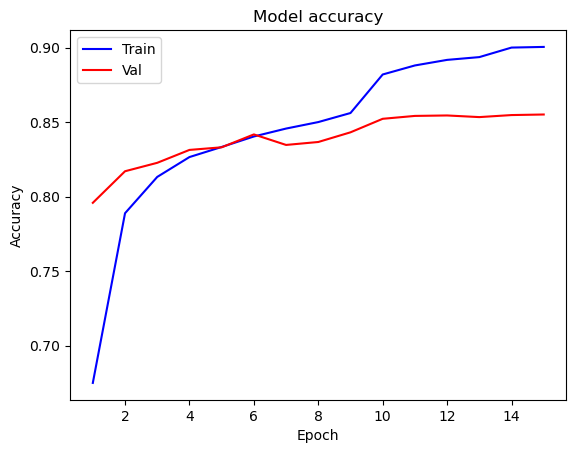

In [28]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

Loss Curve


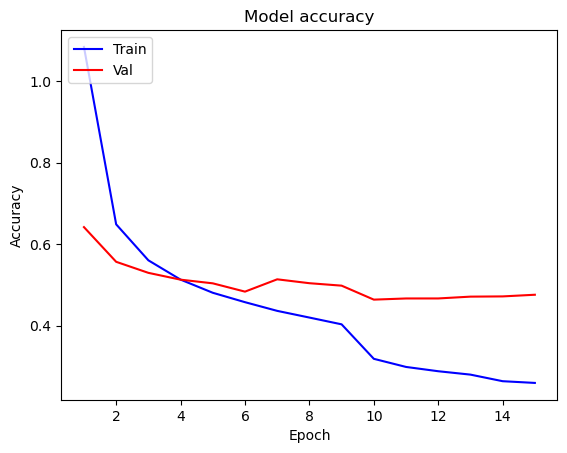

In [29]:
# loss curve
print('Loss Curve')
plotgraph(epochs, loss, val_loss)

### Segmentation and Testing